# Machine learning applied to hyperspectral images <a id="top-notebook"></a>

**Members**:
* louis.guo
* raphael.ramelet
* ilan.guenet

**Table of content**:
* [Load data](#load-data)
* [Dimension reduction](#dimension-reduction)
* [Classification API](#classification-api)
* [Multiclass classification](#multiclass-classification)
    * [With other category](#with-other)
        * [LinearSVC](#linear-svc-1)
        * [RandomForest](#random_forest-1)
        * [K-nearest neighbors](#k-nearest-1)
    * [Without other category](#without-other)
        * [RandomForest](#random_forest-2)
        * [K-nearest neighbors](#k-nearest-2)
    * [Two consecutive classifiers](#two-consecutive-classifiers)
* [Evaluate best classifier](#evaluate-best-classifier)

Import python depedencies. Remember to run ```pip install -r requirements.txt``` before running the notebook

In [1]:
# !pip install -r requirements

# If using pip3
# !pip3 install -r requirements.txt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import seaborn as sn

%matplotlib inline

random_state = 2727

## Load data <a id="load-data"></a>
[Table of content](#top-notebook)

### Hyperspectral image

In [3]:
!ls data/

indianapines_gt.npy  indianapines.npy  salinas_gt.npy  salinas.npy


In [4]:
X_indiana = np.load("data/indianapines.npy").astype('float32')
X_indiana.shape, X_indiana.dtype, np.min(X_indiana), np.max(X_indiana)

((145, 145, 200), dtype('float32'), 955.0, 9604.0)

In [5]:
def plot_rgb(im, title):
    rgb_bands = np.array([30, 15, 2])
    im_rgb = im[:,:,rgb_bands]

    pmin, pmax = np.percentile(im_rgb, (1,99), axis=(0,1))
    
    for i in range(pmin.size):
        # Normalize
        im_rgb[:,:,i] = (im_rgb[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])
        
    im_rgb[im_rgb<0] = 0
    im_rgb[im_rgb>1] = 1
    plt.axis("off")
    plt.title(title)
    plt.imshow(im_rgb)
    plt.plot()

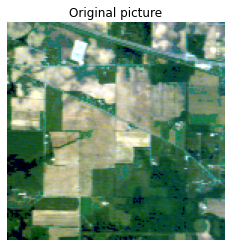

In [6]:
plot_rgb(X_indiana, "Original picture")

### Load labels

In [7]:
y_indiana = np.load("data/indianapines_gt.npy")
y_indiana.shape, y_indiana.dtype, np.min(y_indiana), np.max(y_indiana)

((145, 145), dtype('uint8'), 0, 16)

We can see there are 17 categories. Category 0 is considered as a non-category.

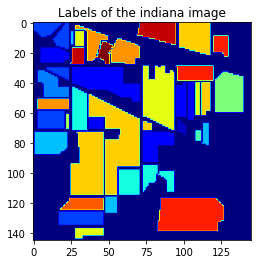

In [8]:
plt.imshow(y_indiana, cmap='jet')
plt.title("Labels of the indiana image")
plt.show()

### Dictionary label to category

In [9]:
label_to_category = { 0: "Other",
                      1: "Alfalfa",
                      2: "Corn-notill",
                      3: "Corn-mintill",
                      4: "Corn",
                      5: "Grass-pasture",
                      6: "Grass-trees",
                      7: "Grass-pasture-mowed",
                      8: "Hay-windrowed",
                      9: "Oats",
                     10: "Soybean-notill",
                     11: "Soybean-mintill",
                     12: "Soybean-clean",
                     13: "Wheat",
                     14: "Woods",
                     15: "Buildings-Grass-Trees-Drives",
                     16: "Stone-Steel-Towers"}
label_to_category   

{0: 'Other',
 1: 'Alfalfa',
 2: 'Corn-notill',
 3: 'Corn-mintill',
 4: 'Corn',
 5: 'Grass-pasture',
 6: 'Grass-trees',
 7: 'Grass-pasture-mowed',
 8: 'Hay-windrowed',
 9: 'Oats',
 10: 'Soybean-notill',
 11: 'Soybean-mintill',
 12: 'Soybean-clean',
 13: 'Wheat',
 14: 'Woods',
 15: 'Buildings-Grass-Trees-Drives',
 16: 'Stone-Steel-Towers'}

### Reshape inputs

In [10]:
# The classifiers requires a 2D matrix.
row, col, dim = X_indiana.shape
X_indiana = X_indiana.reshape((-1, dim))

y_indiana = y_indiana.flatten()
X_indiana.shape, y_indiana.shape

((21025, 200), (21025,))

## Dimension reduction <a id="dimension-reduction"></a>

[Table of content](#top-notebook)

Machine learning is more efficient with lower dimensions. The hyperspectral image have 200 dimensions. That seems way too large for any machine learning algorithm. Thus, we are going to reduce the dimension of the problem using the **P**rincipal **C**omponents **A**nalysis (**PCA**) algorithm.

### Setup PCA

In [11]:
from sklearn.decomposition import PCA

pca = PCA(random_state=random_state)
pca

PCA(random_state=2727)

In [12]:
pca.fit(X_indiana)

PCA(random_state=2727)

### Analyse PCA

In [13]:
print(f"Number of components: {pca.n_components_} (equals to number of wavelength)")

Number of components: 200 (equals to number of wavelength)


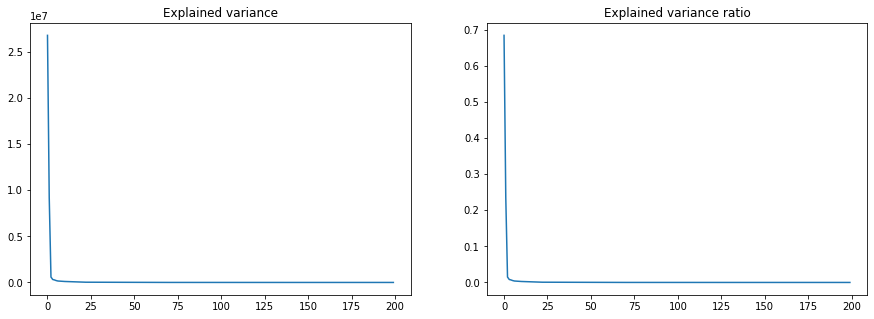

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_)
plt.title("Explained variance")

plt.subplot(1, 2, 2)
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio")
plt.show()

In [15]:
print(f"The first component explains {np.floor(pca.explained_variance_ratio_[0] * 100)}% of the variance")
print(f"The second component explains {np.floor(pca.explained_variance_ratio_[1] * 100)}% of the variance")

The first component explains 68.0% of the variance
The second component explains 23.0% of the variance


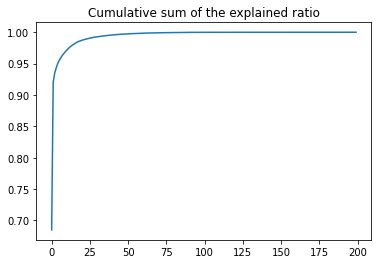

In [16]:
var_cumsum = pca.explained_variance_ratio_.cumsum()

plt.title("Cumulative sum of the explained ratio")
plt.plot(var_cumsum)
plt.show()

We can notice that the first principal components explains most of the variance. So we don't need to keep the last principal components. They usually hold the information of noise. As we want to reduce the dimensions, we are only going to use the first principal components to project data into a new space.

### Make decision

How many principal components are we going to use to project data? We want to project the data in a way that we preserved at least a percentage (threshold) of the variance (information). We can get this information for the cumulative sum of the expained variance. We pick as many principal components until their total explained variance is greater than the threshold.

In [17]:
threshold = 0.95 # 95%

# Number of selected principal components such as the cumulative sum of the explained 
# variance ratio of these principal components is at least greater than the threshold 
nb_pc = np.where(var_cumsum>threshold)[0][0] + 1
print('%d explains at least %1.2f%% of the variance'%(nb_pc, threshold * 100))

5 explains at least 95.00% of the variance


In [18]:
## We need to fit again to use the new params 
pca_params = {"n_components" : nb_pc}
pca = pca.set_params(**pca_params)
pca.fit(X_indiana)

PCA(n_components=5, random_state=2727)

### Projection

In [19]:
# Projection of the data through the new basis from the PCA
Xproj = pca.transform(X_indiana).reshape((row, col, nb_pc))
Xproj.shape

(145, 145, 5)

The hyperspectral image is projected from 200 dimensions to the number of PC dimensions (5 if 95% is the threshold). The dimension are well reduced.

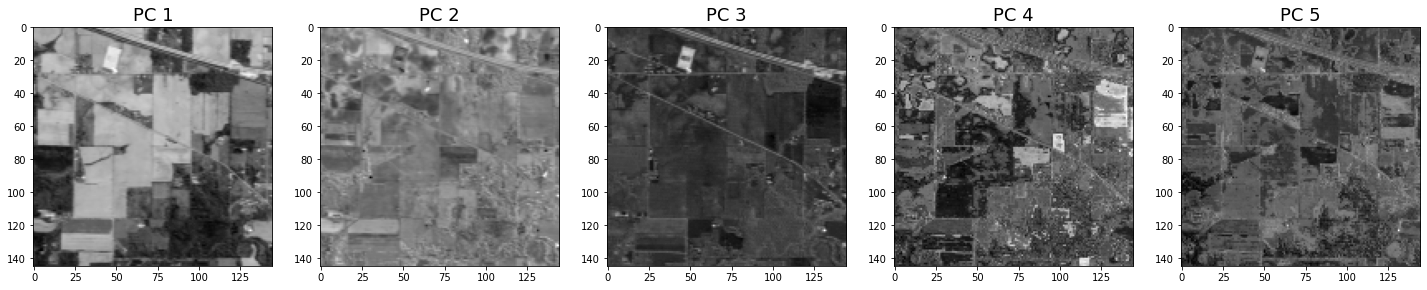

In [20]:
plt.figure(figsize=(30,15))
for i in range(nb_pc):
    plt.subplot(int(nb_pc / 6) + 1,6,i+1)
    plt.title('PC %d'%(i+1),fontsize=18)
    plt.imshow(Xproj[:,:,i],cmap='gray')
plt.show()

In [21]:
Xproj_back = pca.inverse_transform(Xproj) 

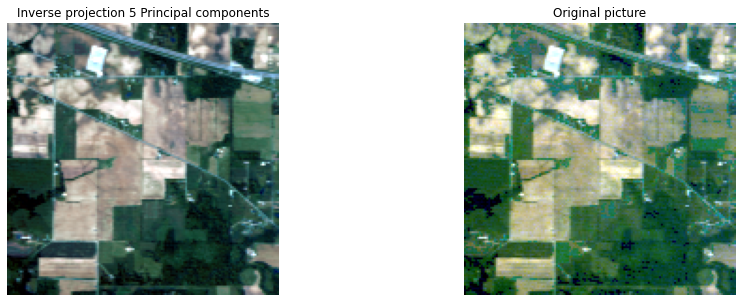

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_rgb(Xproj_back, "Inverse projection " + str(nb_pc) + " Principal components")
plt.subplot(1,2,2)
plot_rgb(X_indiana.reshape(row,col,dim), "Original picture")

### Extra information

#### Mean Square Error (MSE)

In [23]:
def MSE(im1,im2):
    if im1.ndim > 2:
        im1 = im1.reshape((-1,im1.shape[2]))
    if im2.ndim > 2:
        im2 = im2.reshape((-1,im2.shape[2]))
    mse = ((im1-im2)**2).sum(axis=1).mean()
    return mse

In [24]:
MSE(Xproj_back, X_indiana)

1941170.2

In [25]:
nb_pc_range = np.unique(np.round(np.geomspace(1, 190, num=20))).astype(int)
nb_pc_range

array([  1,   2,   3,   4,   5,   7,   9,  12,  16,  21,  27,  36,  48,
        63,  83, 109, 144, 190])

In [26]:
mse_seq = []
for nb_pc_curr in nb_pc_range:
    pca_mse = PCA(n_components = nb_pc_curr, random_state = random_state)
    testproj = pca_mse.fit_transform(X_indiana)
    testproj_back = pca_mse.inverse_transform(testproj).reshape((row,col,dim))
    mse_seq.append(MSE(testproj_back, X_indiana))

mse_seq = np.array(mse_seq)

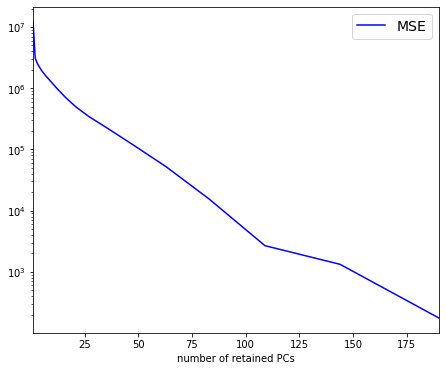

In [27]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(nb_pc_range, mse_seq, 'b', label='MSE')
plt.xlim(nb_pc_range[0], nb_pc_range[-1])
plt.xlabel('number of retained PCs')
plt.yscale('log')
plt.legend(loc='best', fontsize=14)
plt.show()

## Classification API <a id="classification-api"></a>

[Table of content](#top-notebook)


In [43]:
from sklearn.model_selection import GridSearchCV
# / Positional argument before
# * Must name the parameter
def grid_search(pipe, X, y, grid_params, /, *, n_jobs=-1, verbose=4):
    # Create the gridsearch
    # Cross validation gridsearch
    gs = GridSearchCV(pipe, grid_params, n_jobs=n_jobs, verbose=4)
    print("---- Start search ----")
    gs.fit(X, y)
    print("---- Search finished ----")
    print("Best parameter (CV score=%0.3f): " % gs.best_score_)
    print(gs.best_params_)
    return gs.best_params_

In [29]:
from sklearn.metrics import f1_score

def evaluate_clf(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    print("Score: %0.3f." % clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    print("f1 macro score: %0.3f." % f1_score(y_test, y_pred, average='macro'))
    print("f1 weighted score: %0.3f." % f1_score(y_test, y_pred, average='weighted'))

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

def my_classification_report(clf, X, y, classes, clf_name=None):
    y_pred = clf.predict(X)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    df_cm = pd.DataFrame(conf_matrix, classes, classes)
    plt.figure(figsize=(10,10))
    sn.set(font_scale=1.4) # for label size
    ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g', annot_kws={"size": 11}) # font size
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    if clf_name:
        plt.title("Confusion matrix with " + clf_name + " classifier.")
    else:
        plt.tile("Confusion matrix")
        
    ax.plot([1, 0], [0, 1], linewidth=0.2, color='black', transform=ax.transAxes)
    plt.show()
    
    # Classification report
    print(classification_report(y, y_pred, target_names=classes))

## Multiclass classification<a id="multiclass-classification"></a>

[Table of content](#top-notebook)

Documentation:
* <a href="https://scikit-learn.org/stable/modules/multiclass.html">link</a>

### With other category<a id="with-other"></a>

[Table of content](#top-notebook)


In [57]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_indiana, 
                                                    y_indiana, 
                                                    test_size=0.15,
                                                    random_state=random_state)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((17871, 200), (17871,), (3154, 200), (3154,))

#### LinearSVC (One Versus All)<a id="linear-svc-1"></a>

In [32]:
from sklearn.svm import LinearSVC

Pipeline with PCA, LinearSVC

1. Training:
    1. PCA.fit(X_train)
    2. Xproj = pca.transform(X_train)
    3. LinearSVC.fit(Xproj, y_train)
2. Test
    1. Xproj_test = pca.tranform(X_test)
    2. LinearSVC.predict(X_proj_test, y_test)

In [33]:
# Get the number of components for each threshold
thresholds = [0.90, 0.95, 0.99]


pca = PCA(random_state=random_state)
pca.fit(X_train)
param_n_components = []
for threshold in thresholds:
    var_cumsum = pca.explained_variance_ratio_.cumsum()
    param_n_components.append(np.where(var_cumsum>threshold)[0][0] + 1)
    
param_n_components

[2, 5, 25]

In [34]:
max_iter_range = [(i + 1) * 1000 for i in range(4)]
max_iter_range

[1000, 2000, 3000, 4000]

In [35]:
from sklearn.pipeline import Pipeline

# Create pipeline
pca = PCA(random_state=random_state)
linear_svc = LinearSVC(multi_class='ovr', random_state=random_state)

pipe = Pipeline(steps=[('pca', pca), ('linearsvc', linear_svc)])
pipe

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('linearsvc', LinearSVC(random_state=2727))])

In [113]:
# Create the grid search
# Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
grid_params = {
    'pca__n_components': param_n_components,
    'linearsvc__max_iter': max_iter_range,
}

best_params = grid_search(pipe, X_train, y_train, grid_params)

---- Start searching ----
Fitting 5 folds for each of 3 candidates, totalling 15 fits
---- Searching finished ----
Best parameter (CV score=0.280): 
{'linearsvc__max_iter': 1, 'pca__n_components': 25}


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [116]:
# Create pipeline from the best parameters
# linear_svc = LinearSVC(multi_class='ovr', random_state=random_state, max_iter=best_params['linearsvc__max_iter'])
# pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
pca = PCA(random_state=random_state, n_components=5)
linear_svc = LinearSVC(multi_class='ovr', random_state=random_state, max_iter=3000)
pipe = Pipeline(steps=[('pca', pca), ('linearsvc', linear_svc)])

evaluate_clf(pipe, X_train, y_train, X_test, y_test)

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.4254914394419784

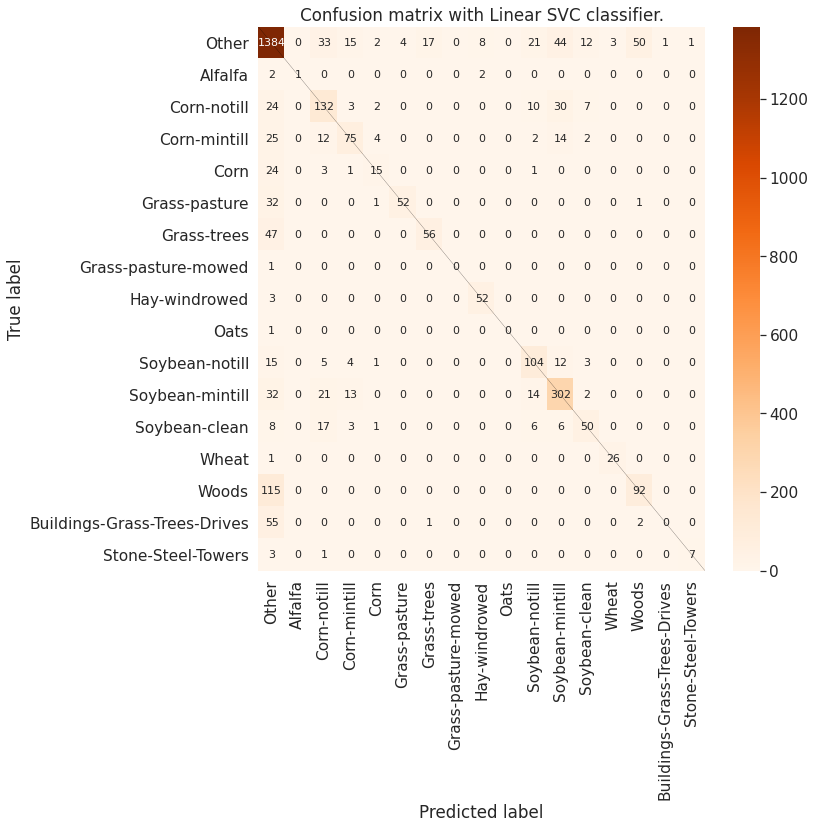

                              precision    recall  f1-score   support

                       Other       0.78      0.87      0.82      1595
                     Alfalfa       1.00      0.20      0.33         5
                 Corn-notill       0.59      0.63      0.61       208
                Corn-mintill       0.66      0.56      0.60       134
                        Corn       0.58      0.34      0.43        44
               Grass-pasture       0.93      0.60      0.73        86
                 Grass-trees       0.76      0.54      0.63       103
         Grass-pasture-mowed       0.00      0.00      0.00         1
               Hay-windrowed       0.84      0.95      0.89        55
                        Oats       0.00      0.00      0.00         1
              Soybean-notill       0.66      0.72      0.69       144
             Soybean-mintill       0.74      0.79      0.76       384
               Soybean-clean       0.66      0.55      0.60        91
                   

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
my_classification_report(pipe, X_test, y_test, label_to_category.values(), clf_name="Linear SVC")

#### RandomForest (Inherently multiclass)<a id="random_forest-1"></a>

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
pca = PCA(random_state=random_state)
random_forest_clf = RandomForestClassifier()
pipe = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])

grid_params = {
    'pca__n_components': param_n_components,
    'random_forest__n_estimators': [100, 500, 1000, 2000],
    'random_forest__class_weight': ["balanced", "balanced_subsample", None]
}
print(pipe)
print(grid_params)

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('random_forest', RandomForestClassifier())])
{'pca__n_components': [2, 5, 25], 'random_forest__n_estimators': [1000], 'random_forest__class_weight': ['balanced', 'balanced_subsample', None]}


In [44]:
%%time
best_params = grid_search(pipe, X_train, y_train, grid_params, n_jobs=4)

---- Start search ----
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/li0nmo0se/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


---- Search finished ----
Best parameter (CV score=0.777): 
{'pca__n_components': 25, 'random_forest__class_weight': None, 'random_forest__n_estimators': 1000}
CPU times: user 1min 32s, sys: 1.9 s, total: 1min 33s
Wall time: 10min 42s


In [45]:
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
random_forest_clf = RandomForestClassifier(random_state=random_state,
                                           n_estimators=best_params['random_forest__n_estimators'],
                                           class_weight=best_params['random_forest__class_weight'])

pipe = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
evaluate_clf(pipe, X_train, y_train, X_test, y_test)

Score: 0.783.
f1 macro score: 0.593.
f1 weighted score: 0.769.


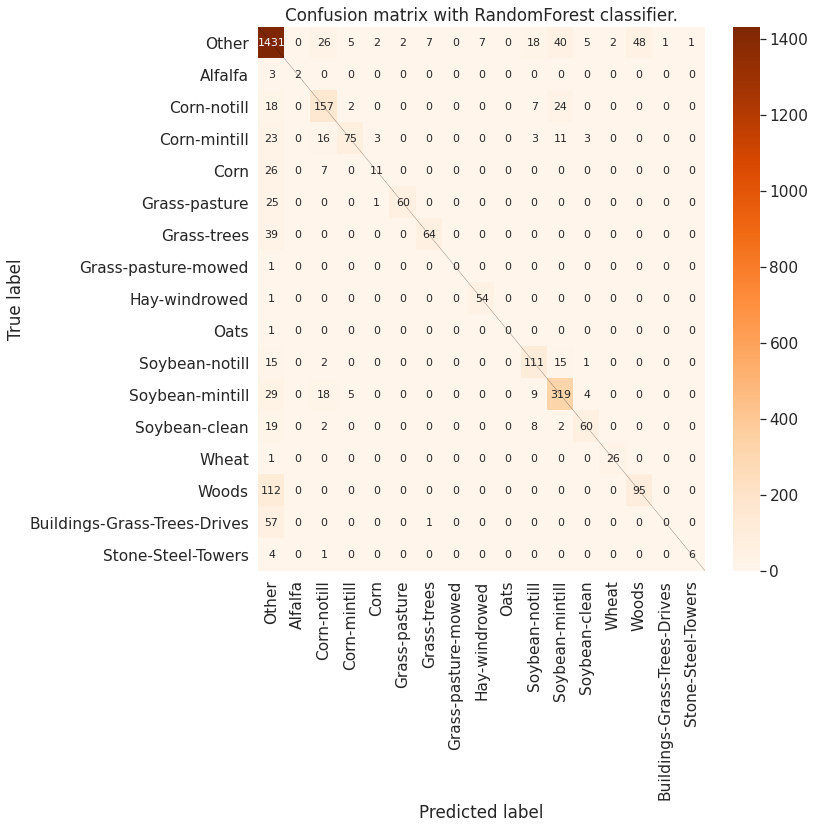

                              precision    recall  f1-score   support

                       Other       0.79      0.90      0.84      1595
                     Alfalfa       1.00      0.40      0.57         5
                 Corn-notill       0.69      0.75      0.72       208
                Corn-mintill       0.86      0.56      0.68       134
                        Corn       0.65      0.25      0.36        44
               Grass-pasture       0.97      0.70      0.81        86
                 Grass-trees       0.89      0.62      0.73       103
         Grass-pasture-mowed       0.00      0.00      0.00         1
               Hay-windrowed       0.89      0.98      0.93        55
                        Oats       0.00      0.00      0.00         1
              Soybean-notill       0.71      0.77      0.74       144
             Soybean-mintill       0.78      0.83      0.80       384
               Soybean-clean       0.82      0.66      0.73        91
                   

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
my_classification_report(pipe, X_test, y_test, label_to_category.values(), "RandomForest")

#### K-nearest neighbors (Inherently multiclass)<a id="k-nearest-1"></a>

In [50]:
from sklearn.neighbors import KNeighborsClassifier

pca = PCA(random_state=random_state)
k_neighbors_clf = KNeighborsClassifier()
pipe = Pipeline(steps=[('pca', pca), ('knn', k_neighbors_clf)])

grid_params = {
    'knn__n_neighbors' : [3,4,5,6,7],
    'knn__weights' : ['distance', 'uniform'],
    'knn__algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 30 , 50],
    'pca__n_components': param_n_components,
}
print(pipe)
print(grid_params)

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('knn', KNeighborsClassifier())])
{'knn__n_neighbors': [3, 4, 5, 6, 7], 'knn__weights': ['distance', 'uniform'], 'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'], 'knn__leaf_size': [10, 30, 50], 'pca__n_components': [2, 5, 25]}


In [52]:
%%time
best_params = grid_search(pipe, X_train, y_train, grid_params)

---- Start search ----
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
---- Search finished ----
Best parameter (CV score=0.733): 
{'knn__algorithm': 'ball_tree', 'knn__leaf_size': 10, 'knn__n_neighbors': 7, 'knn__weights': 'distance', 'pca__n_components': 25}
CPU times: user 4.64 s, sys: 1.27 s, total: 5.9 s
Wall time: 4min 12s


In [58]:
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])

k_neighbors_clf = KNeighborsClassifier(n_neighbors=best_params['knn__n_neighbors'],
                                       weights=best_params['knn__weights'],
                                       algorithm=best_params['knn__algorithm'],
                                       leaf_size=best_params['knn__leaf_size'])

pipe = Pipeline(steps=[('pca', pca), ('knn', k_neighbors_clf)])
evaluate_clf(pipe, X_train, y_train, X_test, y_test)

Score: 0.739.
f1 macro score: 0.573.
f1 weighted score: 0.731.


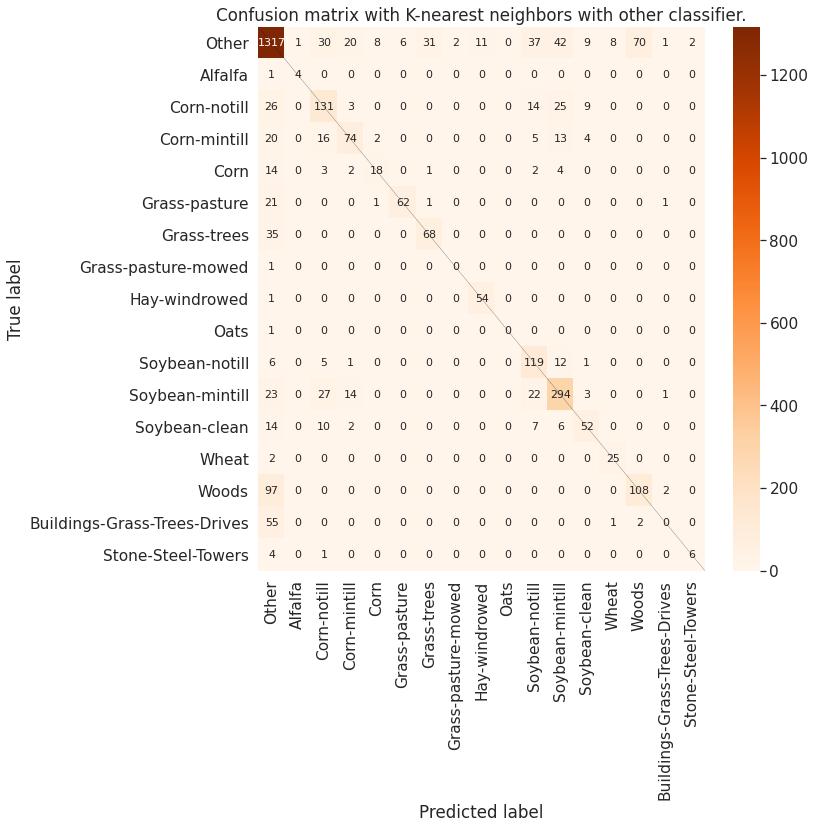

                              precision    recall  f1-score   support

                       Other       0.80      0.83      0.81      1595
                     Alfalfa       0.80      0.80      0.80         5
                 Corn-notill       0.59      0.63      0.61       208
                Corn-mintill       0.64      0.55      0.59       134
                        Corn       0.62      0.41      0.49        44
               Grass-pasture       0.91      0.72      0.81        86
                 Grass-trees       0.67      0.66      0.67       103
         Grass-pasture-mowed       0.00      0.00      0.00         1
               Hay-windrowed       0.83      0.98      0.90        55
                        Oats       0.00      0.00      0.00         1
              Soybean-notill       0.58      0.83      0.68       144
             Soybean-mintill       0.74      0.77      0.75       384
               Soybean-clean       0.67      0.57      0.62        91
                   

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
my_classification_report(pipe, X_test, y_test, label_to_category.values(), "K-nearest neighbors with other")

### Without other category<a id="without-other"></a>

[Table of content](#top-notebook)

In [60]:
# Remove pixels with the unknown category (category 0)
X_indiana_bis = X_indiana[np.where(y_indiana!=0)[0]]
y_indiana_bis = y_indiana[np.where(y_indiana!=0)[0]]
X_indiana_bis.shape, y_indiana_bis.shape

((10249, 200), (10249,))

In [61]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_indiana_bis, 
                                                    y_indiana_bis, 
                                                    test_size=0.15,
                                                    random_state=random_state)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8711, 200), (8711,), (1538, 200), (1538,))

#### RandomForest (Inherently multiclass)<a id="random_forest-2"></a>

In [105]:
pca = PCA(random_state=random_state)
random_forest_clf = RandomForestClassifier(random_state=random_state)
pipe = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])

grid_params = {
    'pca__n_components': param_n_components,
    'random_forest__n_estimators': [100, 500, 1000, 2000],
    'random_forest__class_weight': ["balanced", "balanced_subsample", None]
}
print(pipe)
print(grid_params)

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('random_forest', RandomForestClassifier(random_state=2727))])
{'pca__n_components': [2, 5, 25], 'random_forest__n_estimators': [1000], 'random_forest__class_weight': ['balanced', 'balanced_subsample', None]}


In [106]:
%%time
best_params = grid_search(pipe, X_train, y_train, grid_params)

---- Start search ----
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/li0nmo0se/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


---- Search finished ----
Best parameter (CV score=0.821): 
{'pca__n_components': 25, 'random_forest__class_weight': 'balanced_subsample', 'random_forest__n_estimators': 1000}
CPU times: user 48 s, sys: 2 s, total: 50 s
Wall time: 3min 55s


In [107]:
"""
{'pca__n_components': 25, 'random_forest__class_weight': 'balanced_subsample', 'random_forest__n_estimators': 1000}
"""
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
random_forest_clf = RandomForestClassifier(random_state=random_state,
                                           n_estimators=best_params['random_forest__n_estimators'],
                                           class_weight=best_params['random_forest__class_weight'])

pipe = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
evaluate_clf(pipe, X_train, y_train, X_test, y_test)

Score: 0.813.
f1 macro score: 0.791.
f1 weighted score: 0.807.


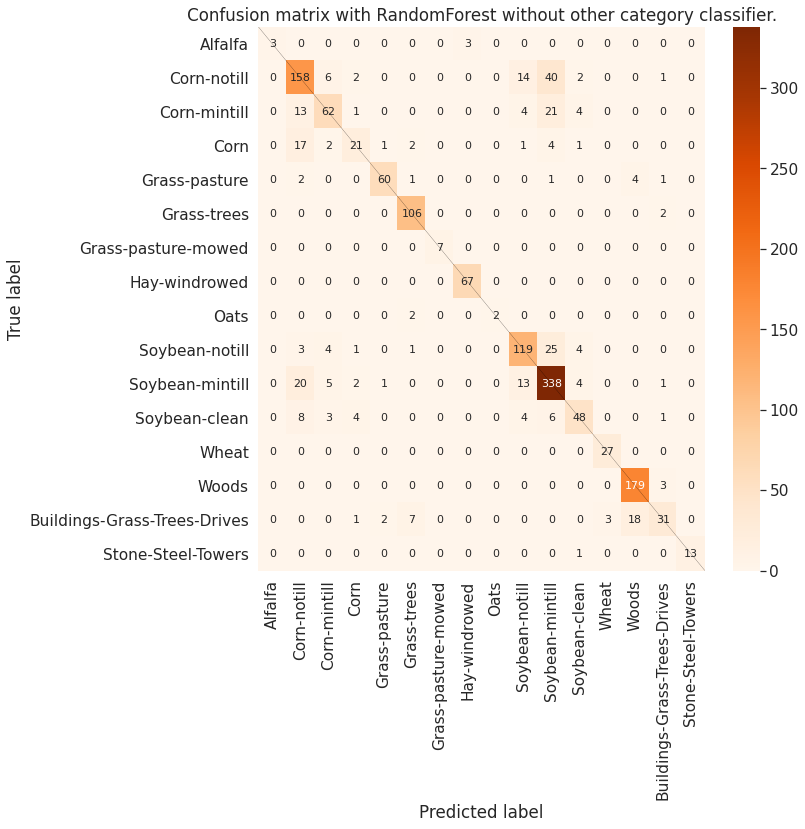

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.50      0.67         6
                 Corn-notill       0.71      0.71      0.71       223
                Corn-mintill       0.76      0.59      0.66       105
                        Corn       0.66      0.43      0.52        49
               Grass-pasture       0.94      0.87      0.90        69
                 Grass-trees       0.89      0.98      0.93       108
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       0.96      1.00      0.98        67
                        Oats       1.00      0.50      0.67         4
              Soybean-notill       0.77      0.76      0.76       157
             Soybean-mintill       0.78      0.88      0.83       384
               Soybean-clean       0.75      0.65      0.70        74
                       Wheat       0.90      1.00      0.95        27
                   

In [108]:
my_classification_report(pipe_random_forest, X_test, y_test, list(label_to_category.values())[1:], "RandomForest without other category")

#### K-nearest neighbors (Inherently multiclass)<a id="k-nearest-2"></a>

In [62]:
from sklearn.neighbors import KNeighborsClassifier

pca = PCA(random_state=random_state)
k_neighbors_clf = KNeighborsClassifier()
pipe = Pipeline(steps=[('pca', pca), ('knn', k_neighbors_clf)])

grid_params = {
    'knn__n_neighbors' : [3,4,5,6,7],
    'knn__weights' : ['distance', 'uniform'],
    'knn__algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 30 , 50],
    'pca__n_components': param_n_components,
}
print(pipe)
print(grid_params)

Pipeline(steps=[('pca', PCA(random_state=2727)),
                ('knn', KNeighborsClassifier())])
{'knn__n_neighbors': [3, 4, 5, 6, 7], 'knn__weights': ['distance', 'uniform'], 'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'], 'knn__leaf_size': [10, 30, 50], 'pca__n_components': [2, 5, 25]}


In [63]:
%%time
best_params = grid_search(pipe, X_train, y_train, grid_params)

---- Start search ----
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
---- Search finished ----
Best parameter (CV score=0.769): 
{'knn__algorithm': 'ball_tree', 'knn__leaf_size': 10, 'knn__n_neighbors': 4, 'knn__weights': 'distance', 'pca__n_components': 25}
CPU times: user 3.9 s, sys: 1.76 s, total: 5.66 s
Wall time: 1min 8s


In [64]:
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])

k_neighbors_clf = KNeighborsClassifier(n_neighbors=best_params['knn__n_neighbors'],
                                       weights=best_params['knn__weights'],
                                       algorithm=best_params['knn__algorithm'],
                                       leaf_size=best_params['knn__leaf_size'])

pipe = Pipeline(steps=[('pca', pca), ('knn', k_neighbors_clf)])
evaluate_clf(pipe, X_train, y_train, X_test, y_test)

Score: 0.787.
f1 macro score: 0.783.
f1 weighted score: 0.783.


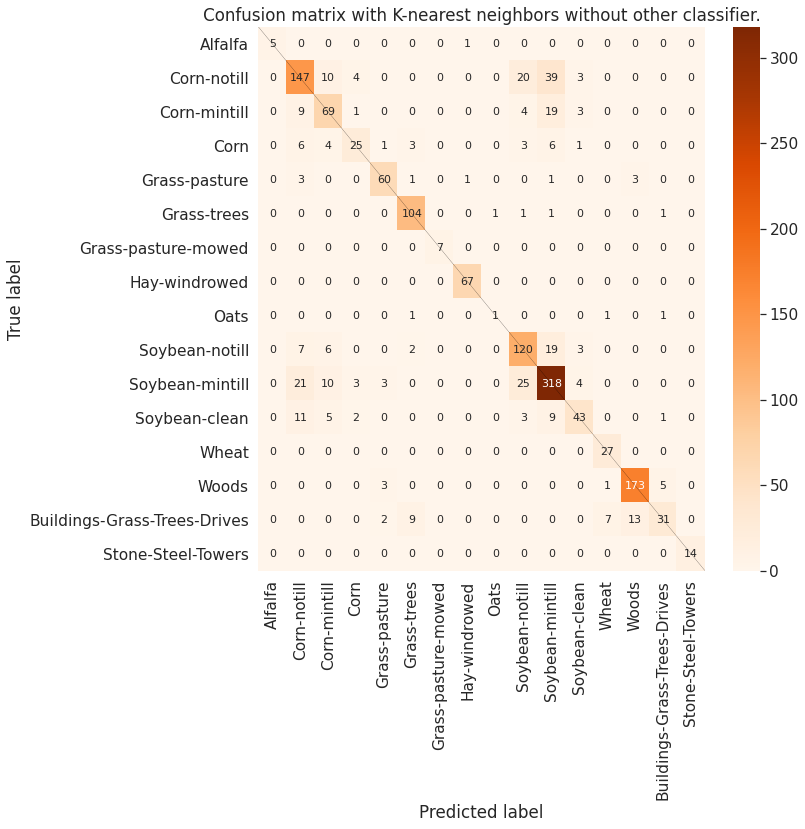

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.83      0.91         6
                 Corn-notill       0.72      0.66      0.69       223
                Corn-mintill       0.66      0.66      0.66       105
                        Corn       0.71      0.51      0.60        49
               Grass-pasture       0.87      0.87      0.87        69
                 Grass-trees       0.87      0.96      0.91       108
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       0.97      1.00      0.99        67
                        Oats       0.50      0.25      0.33         4
              Soybean-notill       0.68      0.76      0.72       157
             Soybean-mintill       0.77      0.83      0.80       384
               Soybean-clean       0.75      0.58      0.66        74
                       Wheat       0.75      1.00      0.86        27
                   

In [67]:
my_classification_report(pipe, X_test, y_test, list(label_to_category.values())[1:], "K-nearest neighbors without other")

### Two consecutive classifiers<a id="two-consecutive-classifiers"></a>
[Table of content](#top-notebook)

In [54]:
y_train_bin = np.where(y_train==0, 0, 1).copy()
y_test_bin = np.where(y_test==0, 0, 1).copy()
X_train.shape, y_train_bin.shape, np.unique(y_train_bin)

((17871, 200), (17871,), array([0, 1]))

In [39]:
pca = PCA(random_state=random_state)
random_forest_clf = RandomForestClassifier()
pipe_bin = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])

grid_params = {
    'pca__n_components': param_n_components,
    'random_forest__n_estimators': [100, 500, 1000, 2000],
}

best_param = grid_search(pipe_bin, X_train, y_train_bin, grid_params)

NameError: name 'param_n_components' is not defined

In [55]:
#pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
#random_forest_clf = RandomForestClassifier(n_estimators=best_params['random_forest__n_estimators'])

pca = PCA(random_state=random_state, n_components=25)
random_forest_clf = RandomForestClassifier(n_estimators=3000)


pipe_bin = Pipeline(steps=[('pca', pca), ('random_forest', random_forest_clf)])
evaluate_clf(pipe_bin, X_train, y_train_bin, X_test, y_test_bin)

Score: 0.831.
f1 macro score: 0.831.
f1 weighted score: 0.831.


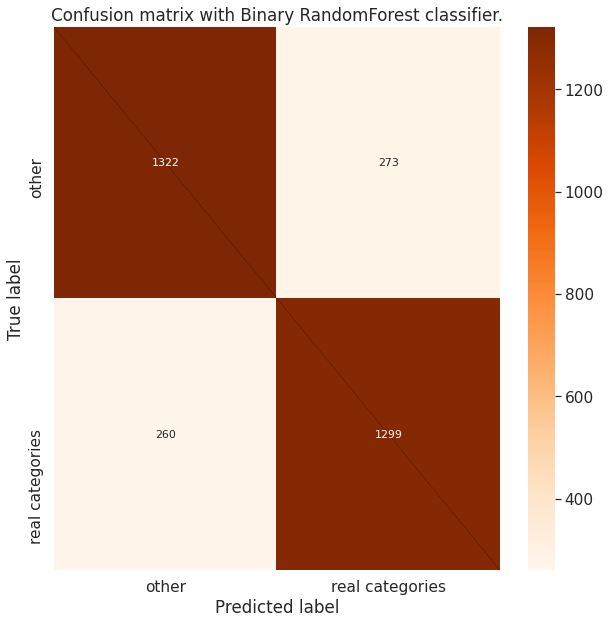

                 precision    recall  f1-score   support

          other       0.84      0.83      0.83      1595
real categories       0.83      0.83      0.83      1559

       accuracy                           0.83      3154
      macro avg       0.83      0.83      0.83      3154
   weighted avg       0.83      0.83      0.83      3154



In [56]:
my_classification_report(pipe_bin, X_test, y_test_bin, ["other", "real categories"], "Binary RandomForest")

In [57]:
res_bin = pipe_bin.predict(X_test)
res = []
for i in range(len(res_bin)):
    if res_bin[i] == 0:
        res.append(0)
    else:
        res.append(pipe_random_forest.predict(X_test[np.newaxis, i])[0])
res = np.array(res, dtype=np.uint8)

In [58]:
print(f1_score(y_test, res, average='macro'))
print(f1_score(y_test, res, average='weighted'))

0.6027956998282946
0.7592999357199787


## Evaluate best classifier<a id="evaluate-best-classifier"></a>

[Table of content](#top-notebook)

Evaluate X_indiana and the second image

y_pred = best_clf.predict(X_indiana)

score(y_indiana, y_pred)